# GloVe : Global Vectors for Word Representation

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

## 1. Load data

In [3]:
#specify the sentences / corpus 
#corpus is define as set of document
#document is basically a nuch of sentence(s)
corpus = ["apple banana fruit", "banana apple fruit", "banana fruit apple", 
          "dog cat animal", "cat dog animal", "cat animal dog"]

In [4]:
#1. tokenize
#usually you use spaCy/ NLTK to tokenize (but we gonna do this later on, we gonna have spaCy)
corpus_tokenized = [sent.split(" ") for sent in corpus]
corpus_tokenized #we called each of this as 'tokens' NOT words

[['apple', 'banana', 'fruit'],
 ['banana', 'apple', 'fruit'],
 ['banana', 'fruit', 'apple'],
 ['dog', 'cat', 'animal'],
 ['cat', 'dog', 'animal'],
 ['cat', 'animal', 'dog']]

In [5]:
#2. numericalize (vocab)

#2.1 get all the unique words
#we want to flatten unit (basically merge all list)
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs = list(set(flatten(corpus_tokenized))) #vocabs is a term degining all unique words your system know
vocabs

['fruit', 'apple', 'dog', 'banana', 'cat', 'animal']

In [6]:
#2.2 assign id to all these vocabs
word2index = {v: idx for idx, v in enumerate(vocabs)}
word2index

{'fruit': 0, 'apple': 1, 'dog': 2, 'banana': 3, 'cat': 4, 'animal': 5}

In [7]:
word2index['dog']

2

In [8]:
#add <UNK>, which is a very normal token exits in the world
vocabs.append('<UNK>') #chaky, can it be ##UNK, or UNKKKKK, or anything

In [9]:
#now we have a way to know what is the id of <UNK>
word2index['<UNK>'] = 6 #usually <UNK> is 0

In [10]:
#create index2word dictionary
# index2word = {idx: v for idx, v in enumerate(vocabs)}
# index2word

# for key,value in word2index.items():
#     print(key,value)

index2word = {v:k for k,v in word2index.items()}
index2word

{0: 'fruit',
 1: 'apple',
 2: 'dog',
 3: 'banana',
 4: 'cat',
 5: 'animal',
 6: '<UNK>'}

In [11]:
vocabs

['fruit', 'apple', 'dog', 'banana', 'cat', 'animal', '<UNK>']

## 2. Co-occurence Matrix X

Count the occurrences of pair of words using window size of 1 (you can use 2, 3, 4, up to you)

E.g., Dog loves to eat meal.

['Dog','loves',1],['loves','to',1]

In [12]:
#use Counter to first count stuffs
from collections import Counter
print(corpus_tokenized)

#count the frequency of each word
#we somehow need this to claiclate the probability Pi
X_i = Counter(flatten(corpus_tokenized)) #merge all list ... (flattten is a function I defines)
# X_i['apple'] #get the probability of apple

[['apple', 'banana', 'fruit'], ['banana', 'apple', 'fruit'], ['banana', 'fruit', 'apple'], ['dog', 'cat', 'animal'], ['cat', 'dog', 'animal'], ['cat', 'animal', 'dog']]


In [13]:
#defome a skipgram of window size 1
skip_grams = []
#loop thriugh each corpus
for sent in corpus_tokenized:
    #loop through each word from i to n-1 (because 0 and n has no context window)
    for idx,i in enumerate(range(1, len(sent)-1)):
        # print(sent[i])
        target = sent[i] #center word
        context = [sent[i-1],sent[i+1]]
        #append(i,i+1) and append(i,i-1)
        for c in context:
            skip_grams.append((target,c))

In [14]:
corpus_tokenized

[['apple', 'banana', 'fruit'],
 ['banana', 'apple', 'fruit'],
 ['banana', 'fruit', 'apple'],
 ['dog', 'cat', 'animal'],
 ['cat', 'dog', 'animal'],
 ['cat', 'animal', 'dog']]

In [15]:
skip_grams

[('banana', 'apple'),
 ('banana', 'fruit'),
 ('apple', 'banana'),
 ('apple', 'fruit'),
 ('fruit', 'banana'),
 ('fruit', 'apple'),
 ('cat', 'dog'),
 ('cat', 'animal'),
 ('dog', 'cat'),
 ('dog', 'animal'),
 ('animal', 'cat'),
 ('animal', 'dog')]

In [16]:
#since we have these occcurences, we can count, to make our co-occurence matrix!!!
X_ik_skipgram = Counter(skip_grams)
X_ik_skipgram

Counter({('banana', 'apple'): 1,
         ('banana', 'fruit'): 1,
         ('apple', 'banana'): 1,
         ('apple', 'fruit'): 1,
         ('fruit', 'banana'): 1,
         ('fruit', 'apple'): 1,
         ('cat', 'dog'): 1,
         ('cat', 'animal'): 1,
         ('dog', 'cat'): 1,
         ('dog', 'animal'): 1,
         ('animal', 'cat'): 1,
         ('animal', 'dog'): 1})

In [17]:
X_ik_skipgram[('banana','animal')]

0

## 3. Weighting function f

GloVe includes a weighting function to scale down too frequent words.

<img src = "figures/glove_weighting_func.png" width=400>

In [18]:
def weighting(w_i,w_j,X_ik): #we need w_i and w_j, because we can try its-co-occurrences, if it's too big, we scale it down
    #check whether the co-occurrences between these two word exits??
    try:
        x_ij = X_ik[(w_i,w_j)]
    except:
        x_ij = 1 #why one, so that the probability thingly won't break....
    
    #maximum co-occurrences; we follow the paper
    x_max = 100
    alpha = 0.75

    #if the co-occurrences does not exceed x_max, cale it down based on some alpha
    if x_ij < x_max:
        result = (x_ij/x_max)**alpha
    else:
        result = 1 #this is the maximum probability you can havve
    
    return result

In [19]:
w_i = 'banana'
w_j = 'fruit'
w_j2 = 'chaky'

print(weighting(w_i,w_j, X_ik_skipgram)) #scale from 1 to 0.0316
print(weighting(w_i,w_j2, X_ik_skipgram))  #the paper says that f(0) = 0

0.03162277660168379
0.0


In [20]:
X_ik_skipgram.get(('banana','fruit'))

1

In [21]:
#now apply this weighting to all possible pairs
from itertools import combinations_with_replacement

X_ik = {} #for keeping the co-occurrences
weighting_dic = {} #for keeping all the probability after passing through the weighting function

for bigram in combinations_with_replacement(vocabs,2): #we need to also think its reverse
    # print(bigram)
    #if this bigram exists in X_ik_skipgrams
    #we gonna add this to our c-occurence matrix
    if X_ik_skipgram.get(bigram) is not None:
        cooc = X_ik_skipgram[bigram] #get the co-occurrences
        X_ik[bigram] = cooc + 1 #this is agian basically label smoothing.... (stability issue (especailly when divide something))
        X_ik[(bigram[1],bigram[0])] = cooc + 1 #trick to get all pairs
    else: #otherwise, do nothing
        pass
    #apply the weighting function using this co-occurrence matrix thingly
    weighting_dic[bigram] = weighting(bigram[0],bigram[1],X_ik)
    weighting_dic[(bigram[1],bigram[0])] = weighting(bigram[1],bigram[0],X_ik)

In [22]:
len(X_ik_skipgram)

12

In [23]:
X_ik

{('fruit', 'apple'): 2,
 ('apple', 'fruit'): 2,
 ('fruit', 'banana'): 2,
 ('banana', 'fruit'): 2,
 ('apple', 'banana'): 2,
 ('banana', 'apple'): 2,
 ('dog', 'cat'): 2,
 ('cat', 'dog'): 2,
 ('dog', 'animal'): 2,
 ('animal', 'dog'): 2,
 ('cat', 'animal'): 2,
 ('animal', 'cat'): 2}

In [24]:
# weighting_dic #give small probability to never-occured is called 'label smoothing

## 4. Prepare train data
You move the window along, and create those tuples as we said in class

In [25]:
for c in corpus_tokenized:
    print(c)

['apple', 'banana', 'fruit']
['banana', 'apple', 'fruit']
['banana', 'fruit', 'apple']
['dog', 'cat', 'animal']
['cat', 'dog', 'animal']
['cat', 'animal', 'dog']


In [26]:
import math

def random_batch(batch_size,word_sequence,skip_grams,X_ik,weighting_dic):
    #loop through skipgram, and change it id because when sending model, it must number 
    skipg_grams_id = [(word2index[skip_gram[0]],word2index[skip_gram[1]]) for skip_gram in skip_grams]
    #randomly pick 'batch_size' indexes
    number_of_choices = len(skipg_grams_id)
    random_index = np.random.choice(number_of_choices, batch_size, replace=False) #no repeating indexes among  these random indexes
    
    # print(random_index)
    random_inputs = [] #xi, wi (in batches)
    random_labels = [] #xj, wj (in batches)
    random_coocs  = [] #xij (in batches)
    random_weighting = [] #f(xij) (in batches)
    #for each of the sample in these indexes
    for i in random_index:
        random_inputs.append([skipg_grams_id[i][0]]) #same reason why I put bracket here....
        random_labels.append([skipg_grams_id[i][1]])

        #get coocs
        #first check whether it exists.....
        pair = skip_grams[i] #e.g., ['banana','fruit']
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1 #label smoothing

        random_coocs.append([math.log(cooc)]) #1. why log, #2 why bracket -> size ==> (,1) #my neural network excepts (,1)
        
        #for weighting
        weighting = weighting_dic[pair] #why not user try... maybe it does not exist
        random_weighting.append(weighting)

    return np.array(random_inputs),np.array(random_labels),np.array(random_coocs),np.array(random_weighting)
        #return xi,xj
        #return cooc Xij
        #return weighting

In [27]:
batch_size = 2
input,target,coocs,weightin = random_batch(batch_size,corpus_tokenized,skip_grams,X_ik,weighting_dic)

In [28]:
input,target,coocs,weightin

(array([[3],
        [2]]),
 array([[1],
        [4]]),
 array([[0.69314718],
        [0.69314718]]),
 array([0.05318296, 0.05318296]))

## 5. Model

<img src ="figures/glove.png">

In [29]:
#the model will accept three vectors - u_o, v_c, u_w
#u_o - vectos for outside words
#v_C - vector for center word
#u_w - vectors of all vocabs

class GloVe(nn.Module):
    def __init__(self,voc_size, emb_size):
        super(GloVe,self).__init__()
        self.embedding_center_word = nn.Embedding(voc_size, emb_size) #is a lookup table mapping all ids in voc_size, into some vector of size emb_size
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
        
        self.bias_i = nn.Embedding(voc_size, 1)
        self.bias_j = nn.Embedding(voc_size, 1)
    def forward(self, center_words, outside_words, coocs, weighting):
        #get the embedding of center_words and outside_words
        center_embeds = self.embedding_center_word(center_words)
        outside_embeds = self.embedding_outside_word(outside_words)

        #create biases #create unique embedding (voc_size,1)
        inner_product = center_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        bias_i = self.bias_i(center_words).squeeze(1) #center
        bias_j = self.bias_j(outside_words).squeeze(1) #target
        #do the product between wi and wj
        loss = weighting * torch.pow(inner_product + bias_i + bias_j - coocs, 2)
        
        return torch.sum(loss)

## 6. Training

In [30]:
voc_size = len(vocabs)
batch_size = 2 #why? no reason
emb_size = 2 #why? no reason; usually 50,100, 300 but 2 so we can plot (50 can also plot, but need PCA)
model = GloVe(voc_size,emb_size)

criterion = nn.CrossEntropyLoss() #-log
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [31]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [32]:
import time
num_epochs = 5000
#for epoch
start_time = time.time()
for epoch in range(num_epochs):
    #get random batch
    input, label, cooc, weightin = random_batch(batch_size,corpus_tokenized,skip_grams,X_ik,weighting_dic)
    input_batch = torch.LongTensor(input)
    label_batch = torch.LongTensor(label)
    cooc_batch = torch.FloatTensor(cooc)
    weightin_batch = torch.FloatTensor(weightin)

    # print(input_batch.shape,label_batch.shape,cooc_batch.shape,weightin_batch.shape)

    #loss = model
    loss = model(input_batch,label_batch,cooc_batch,weightin_batch)
    #backpropagate
    loss.backward()
    #update alpha
    optimizer.step()

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        print(f'Epoch {epoch+1} | Loss {loss:.6f} | Time : {epoch_mins}m {epoch_secs}s')

    # break

Epoch 1000 | Loss 0.070185 | Time : 0m 0s
Epoch 2000 | Loss 0.181298 | Time : 0m 1s
Epoch 3000 | Loss 0.106815 | Time : 0m 2s
Epoch 4000 | Loss 0.003855 | Time : 0m 3s
Epoch 5000 | Loss 0.043862 | Time : 0m 3s


## 7. Plotting the embeddings

Is really the related studd are close to each other, and vice versa.

The most fun part: Will 'banana' closer to 'fruit' than 'cat'?

In [33]:
vocabs

['fruit', 'apple', 'dog', 'banana', 'cat', 'animal', '<UNK>']

In [34]:
banana = torch.LongTensor([word2index['banana']])
banana

tensor([3])

In [35]:
banana_center_embed = model.embedding_center_word(banana)
banana_outside_embed = model.embedding_outside_word(banana)
banana_embed = (banana_center_embed+banana_outside_embed)/2
banana_embed

tensor([[-1.4795,  0.4567]], grad_fn=<DivBackward0>)

In [36]:
#find embedding of fruit, cat
def get_embed(word):
    try:
        index = word2index[word]
    except :
        index = word2index['<UNK>'] #unknown
    word = torch.LongTensor([index])
    
    embed =  (model.embedding_center_word(word)+model.embedding_outside_word(word))/2
    return embed[0][0].item(),embed[0][1].item()
    
print(get_embed('fruit'))
print(get_embed('cat'))
print(get_embed('chaky'))

(-0.21679764986038208, -0.6021071076393127)
(0.5676218271255493, -0.6116302609443665)
(-0.9124876260757446, 0.08380907028913498)


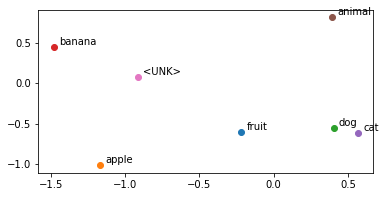

In [37]:
#help me plot fruit cat banana on maplotlib
plt.figure(figsize=(6,3))
for i, word in enumerate(vocabs[:20]):
    x,y = get_embed(word)
    plt.scatter(x,y)
    plt.annotate(word,xy=(x,y),xytext=(5,2),textcoords='offset points')
plt.show()

## 8. Cosine Similarity
How do (from Scratch) calcualte cosine similarity?

Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

If $p$ and $q$ is super similar, the result is 1 otherwise 0.

In [38]:
vocabs

['fruit', 'apple', 'dog', 'banana', 'cat', 'animal', '<UNK>']

In [39]:
#let's try similarity between first and second, and second and third
cat          = get_embed('cat')
fruit        = get_embed('fruit')
animal       = get_embed('animal')

In [40]:
#numpy version
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim
    
print(f"cat vs. fruit: ",cos_sim(cat, fruit))
print(f"cat vs. animal: ",cos_sim(cat, animal))
print(f"cat vs. cat: ",cos_sim(cat, cat))

cat vs. fruit:  0.45919316850865327
cat vs. animal:  -0.3662895741009273
cat vs. cat:  1.0


In [41]:
#scipy version
from scipy import spatial

def cos_sim(a, b):
    cos_sim = 1 - spatial.distance.cosine(a, b)  #distance = 1 - similarlity, because scipy only gives distance
    return cos_sim

print(f"cat vs. fruit: ",cos_sim(cat, fruit))
print(f"cat vs. animal: ",cos_sim(cat, animal))
print(f"cat vs. cat: ",cos_sim(cat, cat))

cat vs. fruit:  0.4591931685086532
cat vs. animal:  -0.36628957410092733
cat vs. cat:  1
